# Splitter tutorial

This notebook presents the possibilities of splitters. They will help to split the train and test data.
RePlay offers several classes:

* DateSplitter
* RandomSplitter
* NewUsersSplitter
* ColdUserRandomSplitter
* UserSplitter

Each of them provides its own capabilities for data split.

### Split data

To split the data, you must call the `.split()` method on the Splitter object

### Return

Splitters return `train` and `test` cached dataframe to compute them once and re-use for models training, inference and metrics calculation.


In [1]:
import pandas as pd

from pyspark.sql import SparkSession

from replay.data_preparator import DataPreparator, Indexer
from replay.experiment import Experiment
from replay.metrics import Coverage, HitRate, NDCG, MAP
from replay.model_handler import save, load, save_indexer, load_indexer
from replay.models import ALSWrap, ItemKNN, SLIM
from replay.session_handler import get_spark_session, State 
from replay.splitters import UserSplitter
from replay.utils import convert2spark, get_log_info

spark = State().session
spark.sparkContext.setLogLevel('ERROR')

/Users/20250847/Desktop/Sber/for_venv/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/20250847/Desktop/Sber/for_venv/venv/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(
22/09/19 14:43:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/09/19 14:43:18 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kube

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from replay.data_preparator import DataPreparator, Indexer
from replay.utils import convert2spark

sns.set_theme(style="whitegrid", palette="muted")

## Get started

Download the dataset **MovieLens** and preprocess it with `DataPreparator` and `Indexer`

In [3]:
ratings = pd.read_csv('./experiments/data/ml1m_ratings.dat',sep="\t",names=["userId", "itemId", "relevance", "timestamp"],engine='python')

In [4]:
ratings.head(5)

,userId,itemId,relevance,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
dp = DataPreparator()
log = dp.transform(data=ratings,
                  columns_mapping={
                      "user_id": "userId",
                      "item_id":  "itemId",
                      "relevance": "relevance",
                      "timestamp": "timestamp"
                  })

log.show(2)

19-Sep-22 14:43:35, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


+-------+-------+---------+-------------------+
|user_id|item_id|relevance|          timestamp|
+-------+-------+---------+-------------------+
|      1|   1193|      5.0|2001-01-01 01:12:40|
|      1|    661|      3.0|2001-01-01 01:35:09|
+-------+-------+---------+-------------------+
only showing top 2 rows



In [8]:
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=log.select('user_id'),
            items=log.select('item_id'))
log = indexer.transform(df=log)
log.show(2)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|    4131|      43|      5.0|2001-01-01 01:12:40|
|    4131|     585|      3.0|2001-01-01 01:35:09|
+--------+--------+---------+-------------------+
only showing top 2 rows



For examples, we will use the first 20 users

In [9]:
log_limit_20 = log.filter("user_idx < 20")

Function for viewing `train`, `test` data

In [10]:
def show_train_test(train, test, user_cat, figs=(15,6),alph=1):
    plt.figure(figsize=figs)
    train_plt = train.toPandas()
    train_plt["split"] = 'train'
    test_plt = test.toPandas()
    test_plt["split"] = 'test'
    pd_for_print = pd.concat((train_plt, test_plt), axis=0)
    if user_cat:
        pd_for_print["user_idx"] = pd_for_print["user_idx"].astype(str)
    sns.scatterplot(data=pd_for_print, x="timestamp", y="user_idx", hue="split",s=8*8,alpha=alph)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()

## General parameters of splitters

All splitters has the following common parameters:
* `drop_cold_users` flag to drop cold items from test

* `drop_cold_items` flag to drop cold users from test

* `drop_zero_rel_in_test` flag to remove entries with relevance <= 0

* `date_col` timestamp column name

* `user_col` user id column name

* `item_col` item id column name

## class DateSplitter()

Split into train and test by date.

#### Parameters other than gneral

* `test_start` string "yyyy-mm-dd" , int unix timestamp, datetime or a fraction for test size to determine the date automatically


In this example `test_start` parameter will take fraction for test size

In [11]:
from replay.splitters.log_splitter import DateSplitter

date_splitter = DateSplitter(
    test_start=0.05,
    drop_cold_users=True,
    drop_cold_items=True,
    drop_zero_rel_in_test=True
)

In [12]:
train, test = date_splitter.split(log_limit_20)

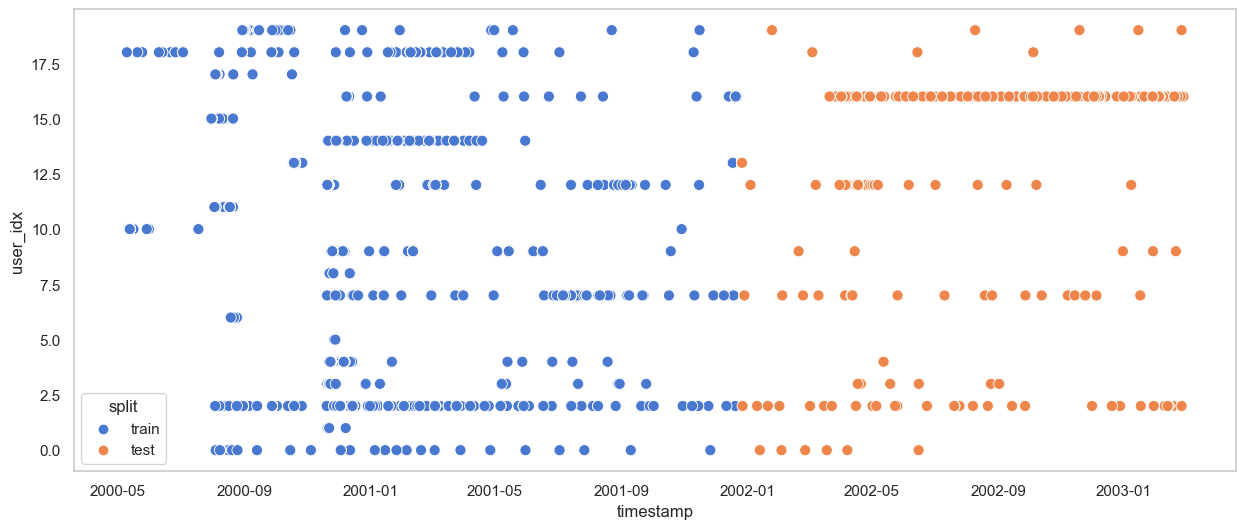

In [13]:
show_train_test(train, test, 0)

In [14]:
get_log_info(train)

'total lines: 26816, total users: 20, total items: 3303'

In [15]:
get_log_info(test)

'total lines: 1387, total users: 11, total items: 1152'

In this example `test_start` parameter will take string "yyyy-mm-dd"

In [16]:
from replay.splitters.log_splitter import DateSplitter

date_splitter = DateSplitter(
    test_start="2001-09",
    drop_cold_users=True,
    drop_cold_items=True,
    drop_zero_rel_in_test=True
)

In [17]:
train, test = date_splitter.split(log_limit_20)

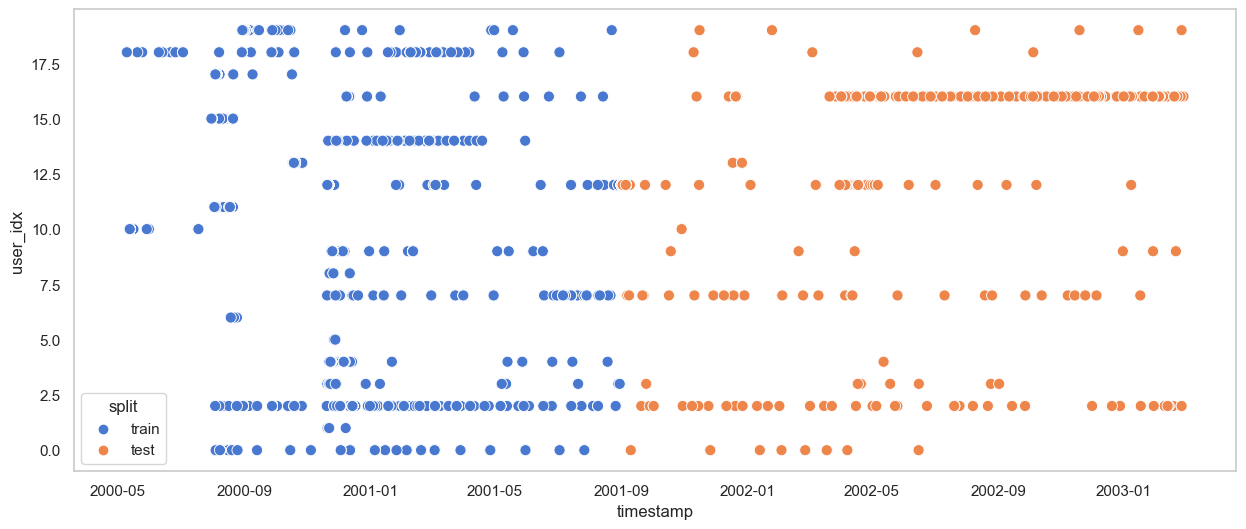

In [18]:
show_train_test(train, test, 0)

In [19]:
get_log_info(train)

'total lines: 26345, total users: 20, total items: 3281'

In [20]:
get_log_info(test)

'total lines: 1834, total users: 12, total items: 1399'

### Learn more about the parameters `drop_cold_users`, `drop_cold_items`, `drop_zero_rel_in_test`

#### All parameters is false

In [21]:
from replay.splitters.log_splitter import DateSplitter
from replay.utils import get_log_info

date_splitter = DateSplitter(
    test_start=0.3,
    drop_cold_users=False,
    drop_cold_items=False,
    drop_zero_rel_in_test=False
)

Let's look at the result of filtering using the function  `get_log_info()`

In [22]:
train, test = date_splitter.split(log)
get_log_info(train.union(test))

'total lines: 1000209, total users: 6040, total items: 3706'

#### `drop_cold_users` is True 

In [23]:
date_splitter = DateSplitter(
    test_start=0.3,
    drop_cold_users=True,
    drop_cold_items=False,
    drop_zero_rel_in_test=False
)

In [24]:
train, test = date_splitter.split(log)
get_log_info(train.union(test))

'total lines: 811313, total users: 4870, total items: 3682'

#### `drop_cold_items` is True 

In [25]:
date_splitter = DateSplitter(
    test_start=0.3,
    drop_cold_users=False,
    drop_cold_items=True,
    drop_zero_rel_in_test=False
)

In [26]:
train, test = date_splitter.split(log)
get_log_info(train.union(test))

'total lines: 1000038, total users: 6040, total items: 3633'

#### `drop_zero_rel_in_test` is True 

In [27]:
date_splitter = DateSplitter(
    test_start=0.3,
    drop_cold_users=False,
    drop_cold_items=False,
    drop_zero_rel_in_test=True
)

In [28]:
train, test = date_splitter.split(log)
get_log_info(train.union(test))

'total lines: 1000209, total users: 6040, total items: 3706'

## class RandomSplitter()

Assign records into train and test at random.

#### Parameters other than gneral

* `test_size` float 

* `seed` random seed

In [29]:
from replay.splitters.log_splitter import RandomSplitter

random_splitter = RandomSplitter(
    test_size=0.4,
    drop_cold_users=True,
    drop_cold_items=True,
    drop_zero_rel_in_test=True
)

In [30]:
train, test = random_splitter.split(log_limit_20)

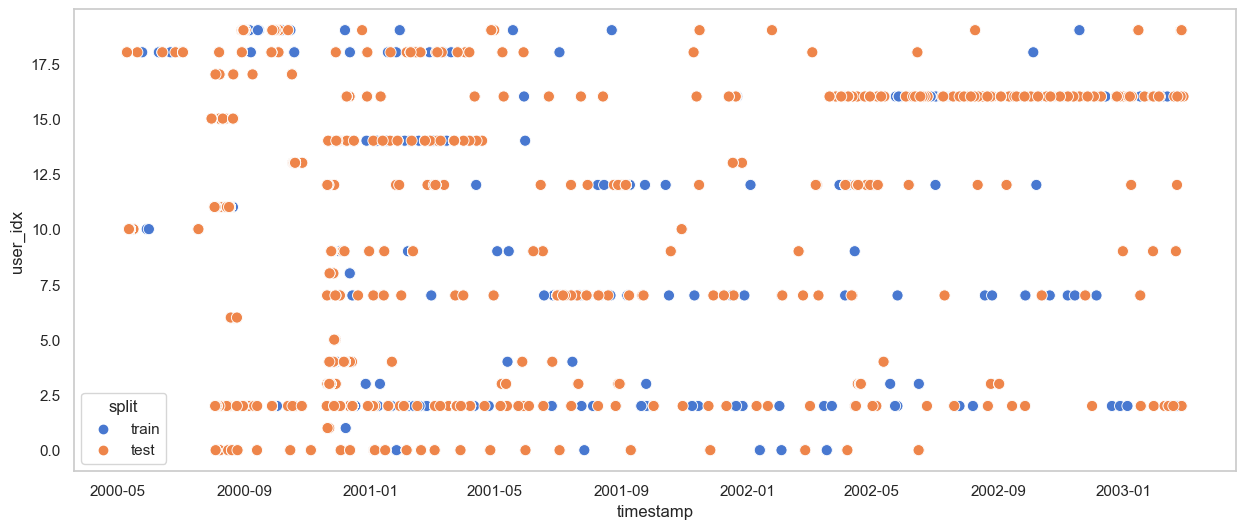

In [31]:
show_train_test(train, test, 0)

In [32]:
get_log_info(train)

'total lines: 17087, total users: 20, total items: 3149'

In [33]:
get_log_info(test)

'total lines: 10856, total users: 20, total items: 2753'

## class NewUsersSplitter()

Only new users will be assigned to test set.
Splits log by timestamp so that test has `test_size` fraction of most recent users.

#### Parameters other than gneral

* `test_size` float 

In [34]:
from replay.splitters.log_splitter import NewUsersSplitter

new_user_splitter = NewUsersSplitter(
    test_size=0.3
)

In [35]:
train, test = new_user_splitter.split(log_limit_20)

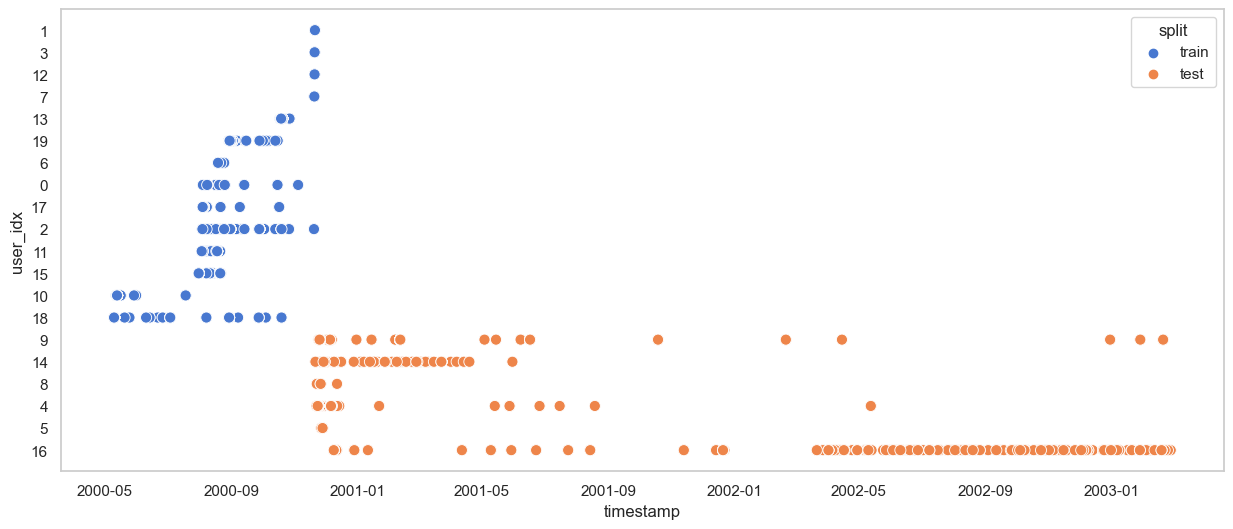

In [36]:
show_train_test(train, test, 1)

In [37]:
get_log_info(train)

'total lines: 13952, total users: 14, total items: 2931'

In [38]:
get_log_info(test)

'total lines: 8096, total users: 6, total items: 2757'

## class ColdUserRandomSplitter()

Test set consists of all actions of randomly chosen users.

#### Parameters other than gneral

* `test_size` float 

* `seed` random seed

In [39]:
from replay.splitters.log_splitter import ColdUserRandomSplitter

cold_user_random_splitter = ColdUserRandomSplitter(
    test_size=0.3
)

In [40]:
train, test = cold_user_random_splitter.split(log_limit_20)

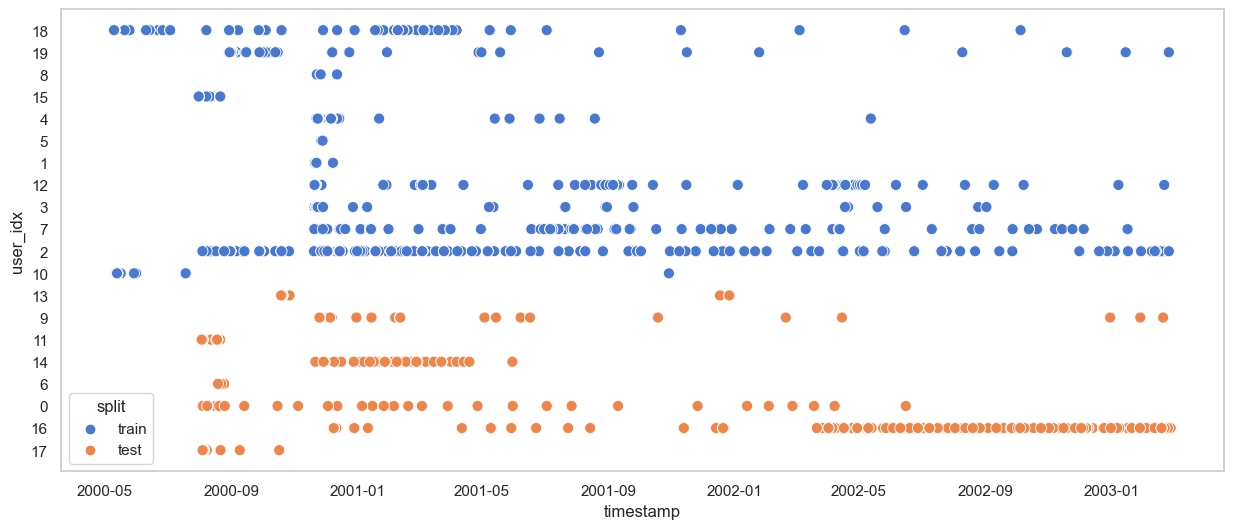

In [41]:
show_train_test(train, test,1)

In [42]:
get_log_info(train)

'total lines: 17065, total users: 12, total items: 3164'

In [43]:
get_log_info(test)

'total lines: 11164, total users: 8, total items: 2999'

## class UserSplitter()

Split data inside each user's history separately.

#### Parameters other than gneral

* `item_test_size` Number of items to be added to the test for each user

* `user_test_size` Number of users to be added to the test

* `seed` random seed

In this example 10 users are randomly selected, 50 products are included in the test for each user. `shuffle` parameter is False. Separation in each selected user occurs on a timeline

In [47]:
from replay.splitters.user_log_splitter import UserSplitter

user_splitter = UserSplitter(
    item_test_size=50,
    user_test_size=10,
    shuffle=False
)

In [48]:
train, test = user_splitter.split(log_limit_20)

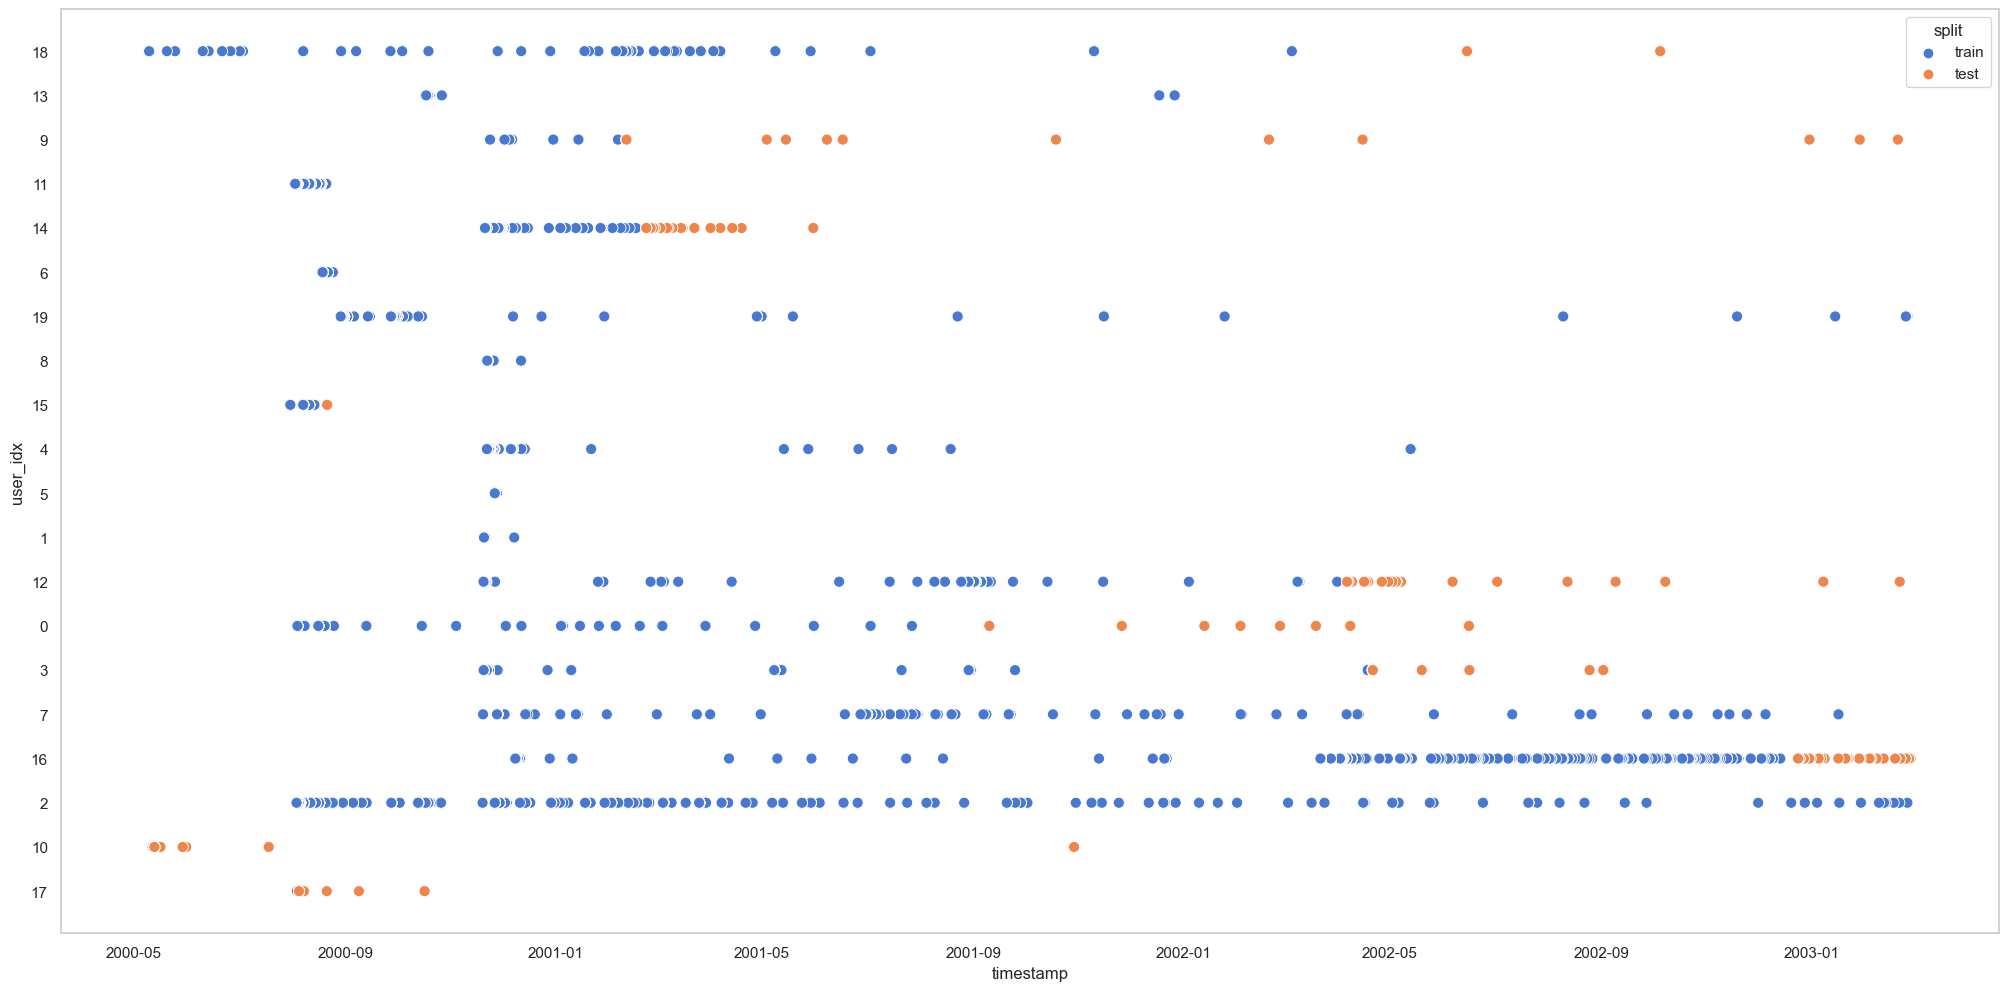

In [49]:
show_train_test(train, test, 1,(25,12))

In [50]:
get_log_info(train)

'total lines: 27729, total users: 20, total items: 3301'

In [51]:
get_log_info(test)

'total lines: 500, total users: 10, total items: 468'

In this example 10 users are randomly selected, 50 products are included in the test for each user. In this example `shuffle` parameter is True. Split in each selected user occurs random

In [52]:
from replay.splitters.user_log_splitter import UserSplitter

user_splitter = UserSplitter(
    item_test_size=50,
    user_test_size=10,
    shuffle=True
)

In [53]:
train, test = user_splitter.split(log_limit_20)

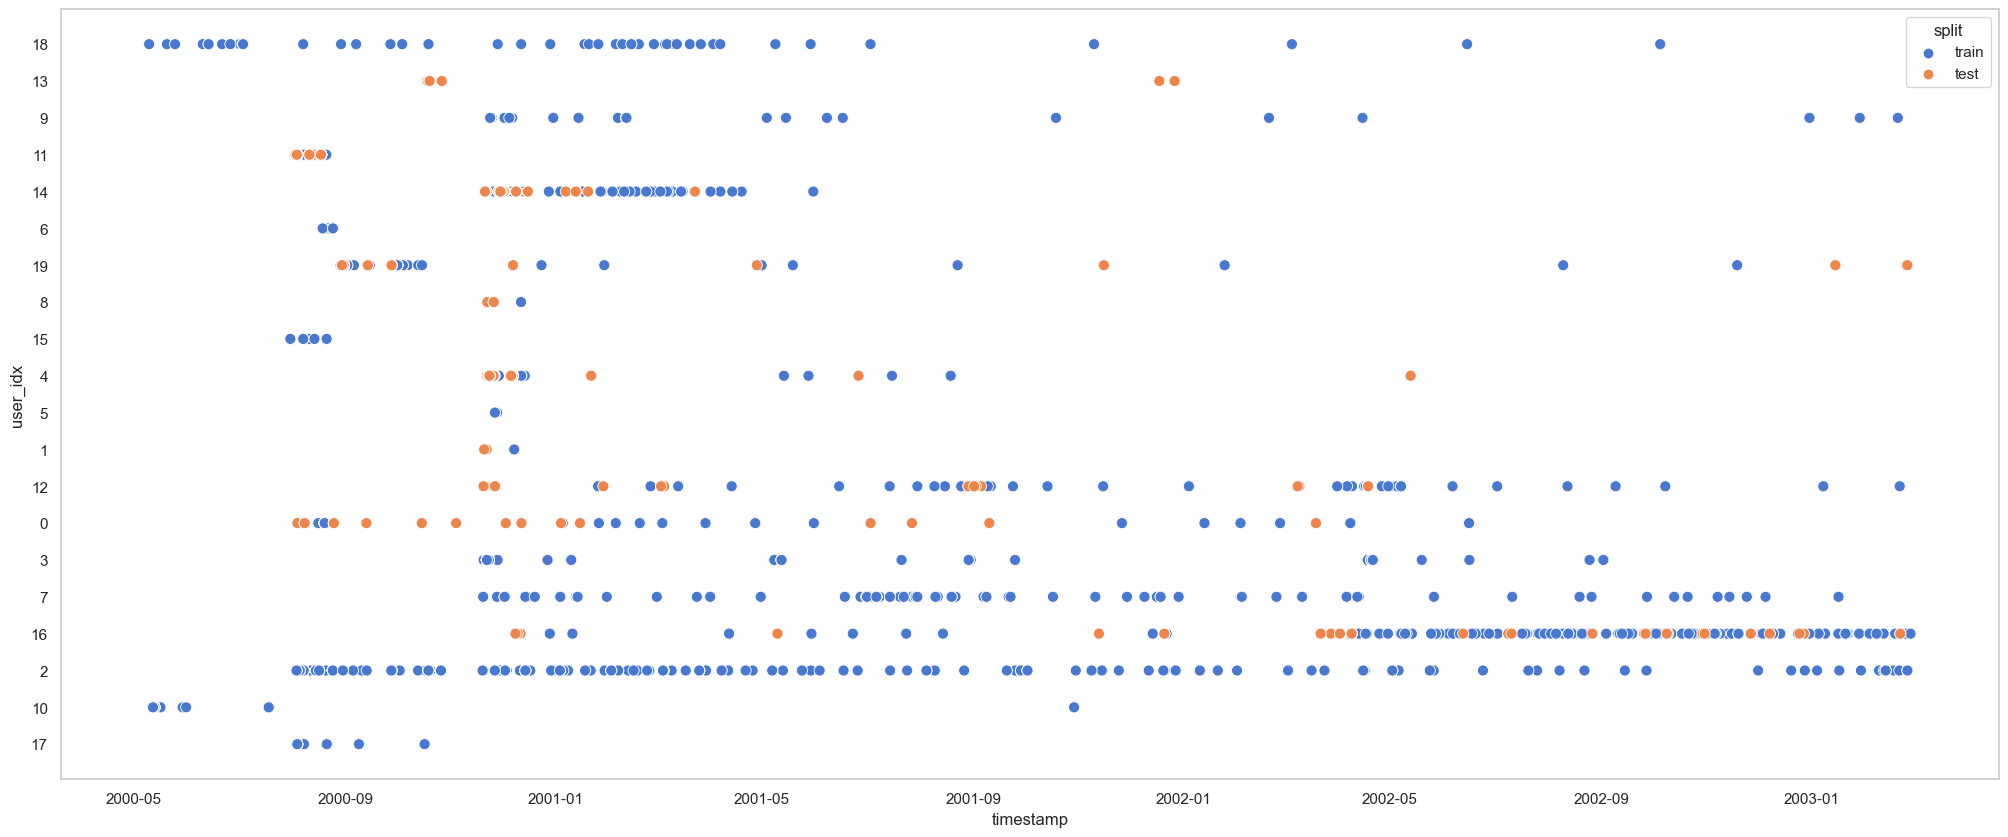

In [54]:
show_train_test(train, test, 1,(25,10))

In [55]:
get_log_info(train)

'total lines: 27729, total users: 20, total items: 3321'

In [56]:
get_log_info(test)

'total lines: 500, total users: 10, total items: 459'

You can use **float** as input for `item_test_size` or `user_test_size` parameters

In [57]:
from replay.splitters.user_log_splitter import UserSplitter

user_splitter = UserSplitter(
    item_test_size=0.015,
    user_test_size=0.5,
    shuffle=True
)

In [58]:
train, test = user_splitter.split(log_limit_20)

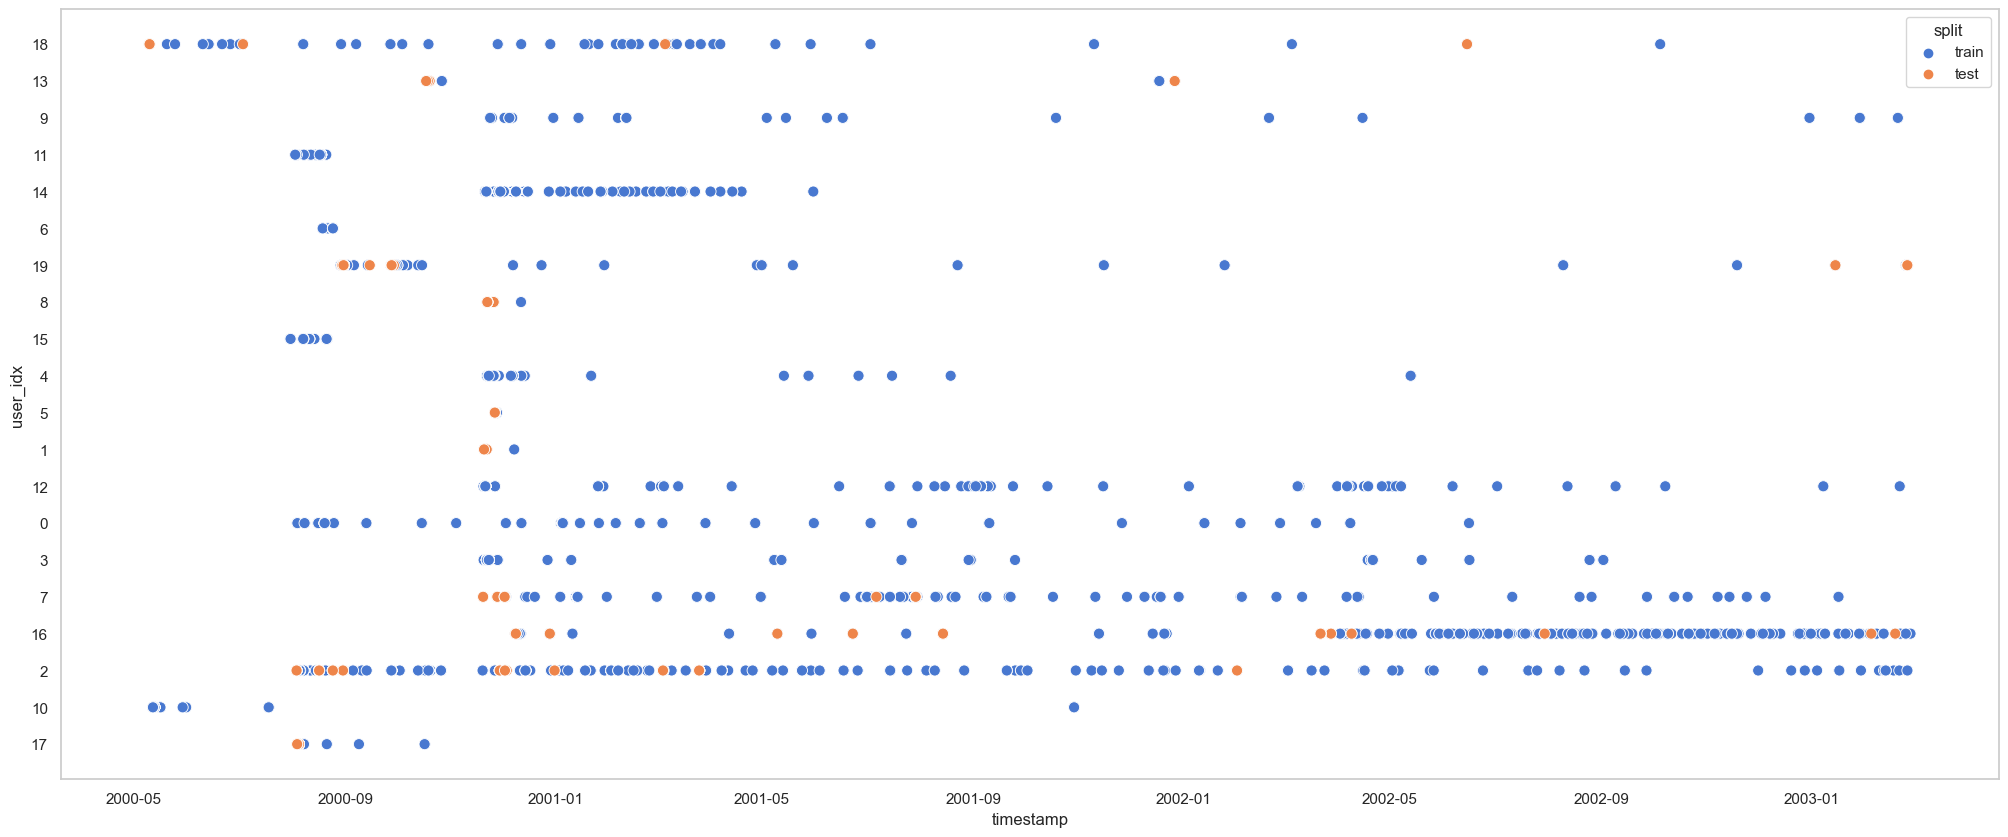

In [59]:
show_train_test(train, test, 1,(25,10))

In [60]:
get_log_info(train)

'total lines: 28026, total users: 20, total items: 3322'

In [61]:
get_log_info(test)

'total lines: 203, total users: 10, total items: 197'